In [1]:
import torch 
import torch.nn as nn
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 2, 20

In [4]:
np.linspace(0,1,500)[0]

0.0

In [5]:
x = np.linspace(0,1,500)
x_test=np.linspace(1,2,500)

In [6]:
x = np.array([x for _ in range(100)])
x_test= np.array([x_test for _ in range(100)])
y

(100, 500) (100, 500)


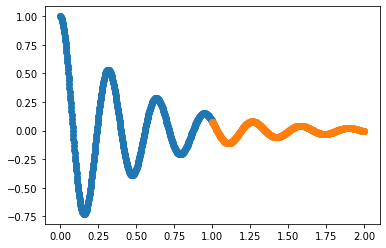

In [7]:

N = 100 # number of samples

y = oscillator(d, w0, x).astype(np.float32)
y_test =oscillator(d, w0, x_test).astype(np.float32)
print(x.shape,y.shape)
plt.scatter(x[1],y[1])
plt.scatter(x_test[1],y_test[1])

In [14]:
y

array([[ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405],
       [ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405],
       [ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405],
       ...,
       [ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405],
       [ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405],
       [ 0.07911602,  0.07434347,  0.06949008, ..., -0.00635696,
        -0.00701876, -0.00766405]], dtype=float32)

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, outputs)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=0.8)

        
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    
    
    
    
    
    

2 min 

In [22]:
inpu

tensor([[1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838],
        [1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838],
        [1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838],
        ...,
        [1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838],
        [1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838],
        [1.0000, 0.9992, 0.9968,  ..., 0.0929, 0.0884, 0.0838]])

array([ 1.00063229e+00,  9.93274212e-01,  9.94341195e-01,  9.90103722e-01,
        9.81642127e-01,  9.71221566e-01,  9.59975719e-01,  9.48113084e-01,
        9.35434222e-01,  9.21666920e-01,  9.06606734e-01,  8.90146255e-01,
        8.72257650e-01,  8.52964818e-01,  8.32320631e-01,  8.10391188e-01,
        7.87247419e-01,  7.62960076e-01,  7.37598538e-01,  7.11230874e-01,
        6.83922768e-01,  6.55739188e-01,  6.26743793e-01,  5.96999526e-01,
        5.66568077e-01,  5.35510123e-01,  5.03884733e-01,  4.71749902e-01,
        4.39161479e-01,  4.06173706e-01,  3.72839332e-01,  3.39209199e-01,
        3.05332959e-01,  2.71258652e-01,  2.37034261e-01,  2.02707052e-01,
        1.68324351e-01,  1.33934259e-01,  9.95857716e-02,  6.53287172e-02,
        3.12147141e-02, -2.70366669e-03, -3.63727808e-02, -6.97381496e-02,
       -1.02744937e-01, -1.35338545e-01, -1.67464495e-01, -1.99070215e-01,
       -2.30103850e-01, -2.60515928e-01, -2.90258884e-01, -3.19288015e-01,
       -3.47559929e-01, -

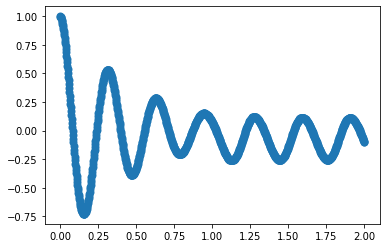

In [30]:
plt.scatter(np.linspace(0,2,d_t), y[0], linewidth = 2.0) 

STEP:  0
loss: 0.1396332085132599
loss: 0.13158999383449554
loss: 0.12615422904491425
loss: 0.1252409964799881
loss: 0.1235985979437828
loss: 0.11951195448637009
loss: 0.10805456340312958
loss: 0.024462604895234108
loss: 0.02245509624481201
loss: 0.021421214565634727
loss: 0.006910533178597689
loss: 0.005198265425860882
loss: 0.004944779444485903
loss: 0.004915028344839811
loss: 0.004750629886984825
loss: 0.004457108210772276
loss: 0.0038176379166543484
loss: 0.002758422400802374
loss: 0.0012832175707444549
loss: 0.0006300709210336208
test loss: 0.0005763949011452496
0.8568511


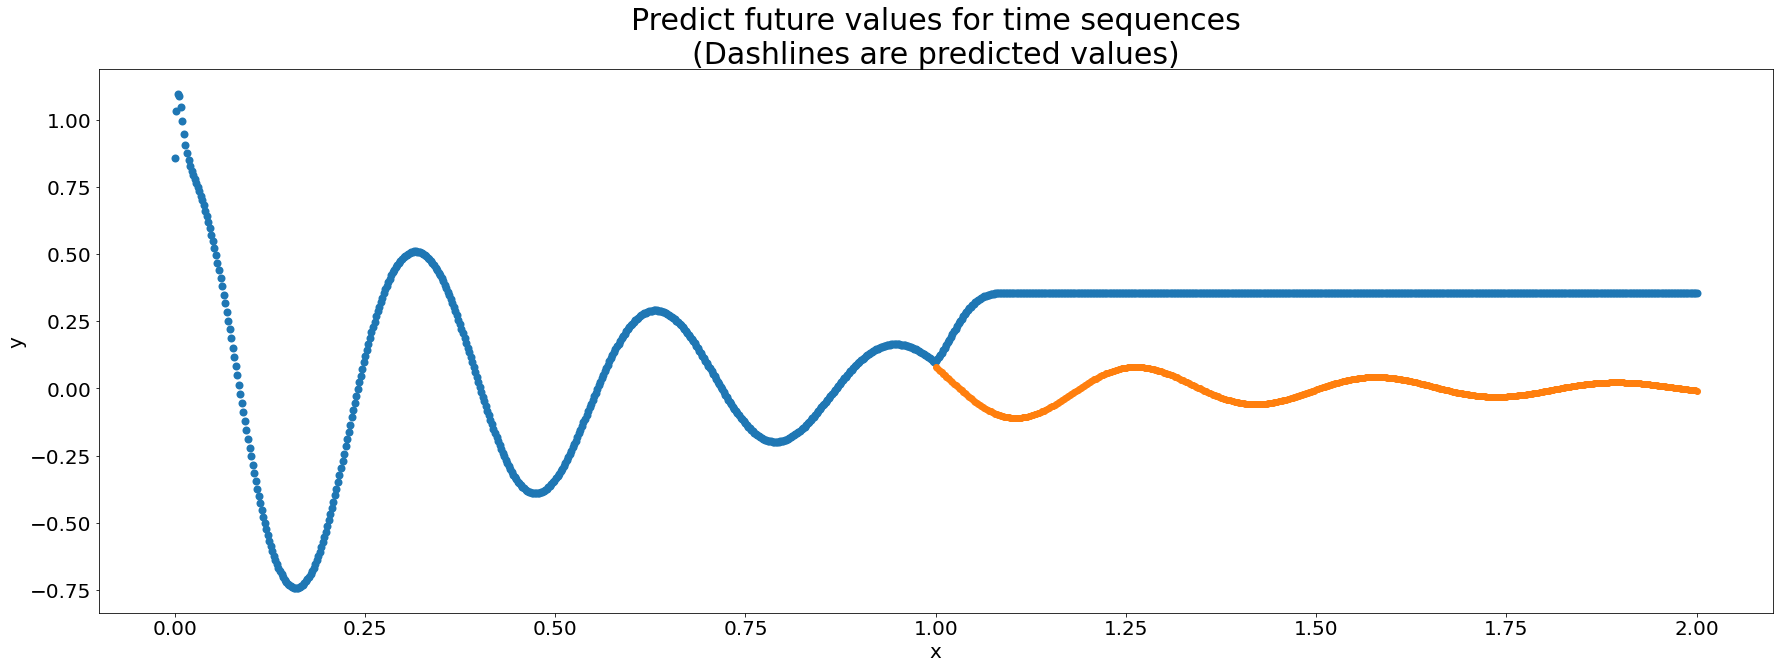

STEP:  1
loss: 0.0005763949593529105
loss: 0.0005427870783023536
loss: 0.000539297005161643
loss: 0.0005366987898014486
loss: 0.0005305015947669744
loss: 0.0005192933022044599
loss: 0.000500545313116163
loss: 0.00047110908781178296
loss: 0.00042232227860949934
loss: 0.0003654086322057992
loss: 0.0003462787135504186
loss: 0.0003442013403400779
loss: 0.0003431352670304477
loss: 0.00034230135497637093
loss: 0.0003408108896110207
loss: 0.00033744837855920196
loss: 0.0003294415364507586
loss: 0.0003069239901378751
loss: 0.0004894501180388033
loss: 0.0002488966565579176
test loss: 0.00023096881341189146
0.8381402


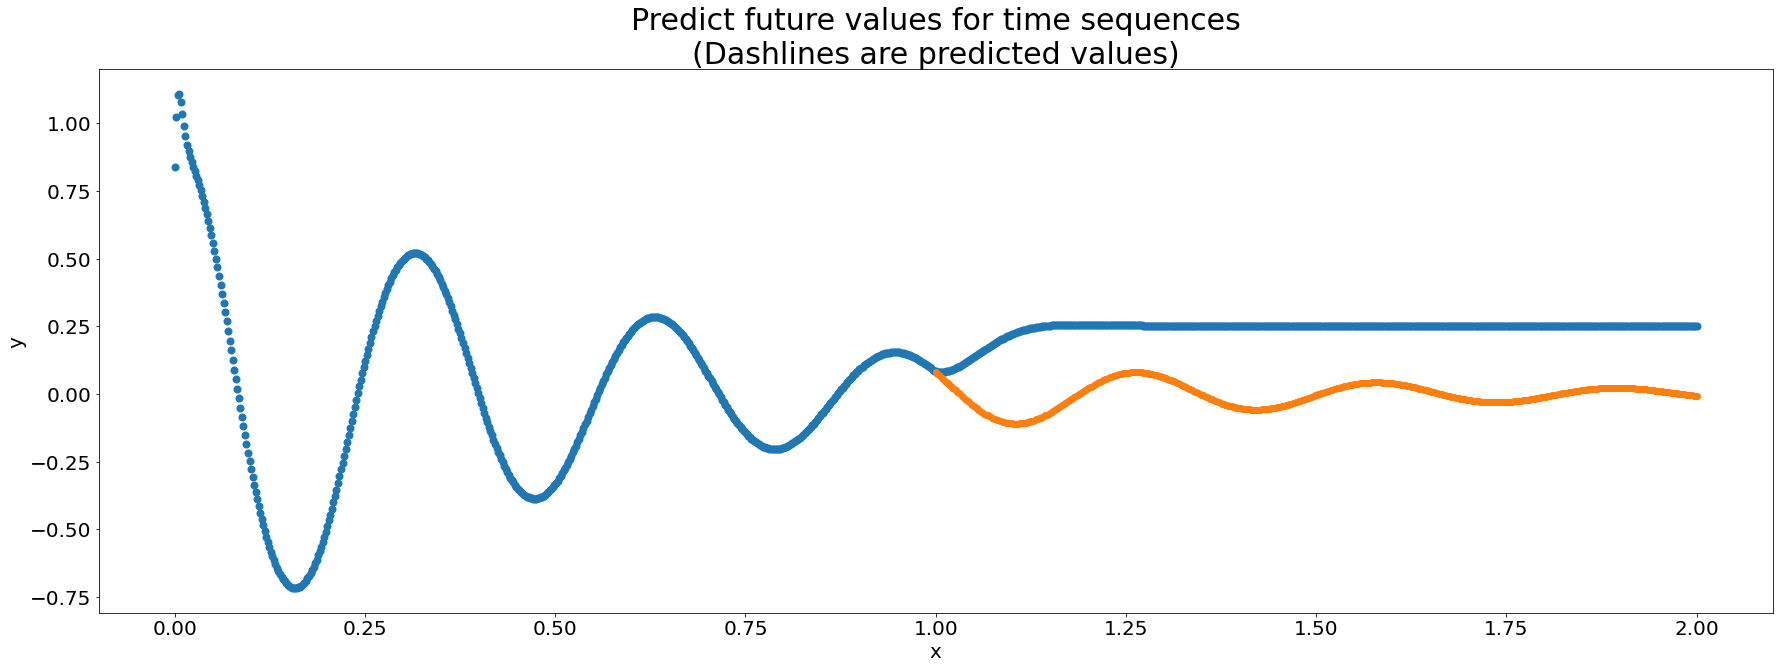

STEP:  2
loss: 0.00023096881341189146
loss: 0.00023590915952809155
loss: 0.0001910671271616593
loss: 0.000189004756975919
loss: 0.00018760525563266128
loss: 0.00018718130013439804
loss: 0.00018570892279967666
loss: 0.00018118620209861547
loss: 0.00017469875456299633
loss: 0.0001723274908727035
loss: 0.0001705982576822862
loss: 0.000166506550158374
loss: 0.0001566690916661173
loss: 0.00013976807531435043
loss: 0.00012268259888514876
loss: 0.00010056281462311745
loss: 8.162977610481903e-05
loss: 6.893813406350091e-05
loss: 6.861107976874337e-05
loss: 6.688160647172481e-05
test loss: 6.662811210844666e-05
0.92395127


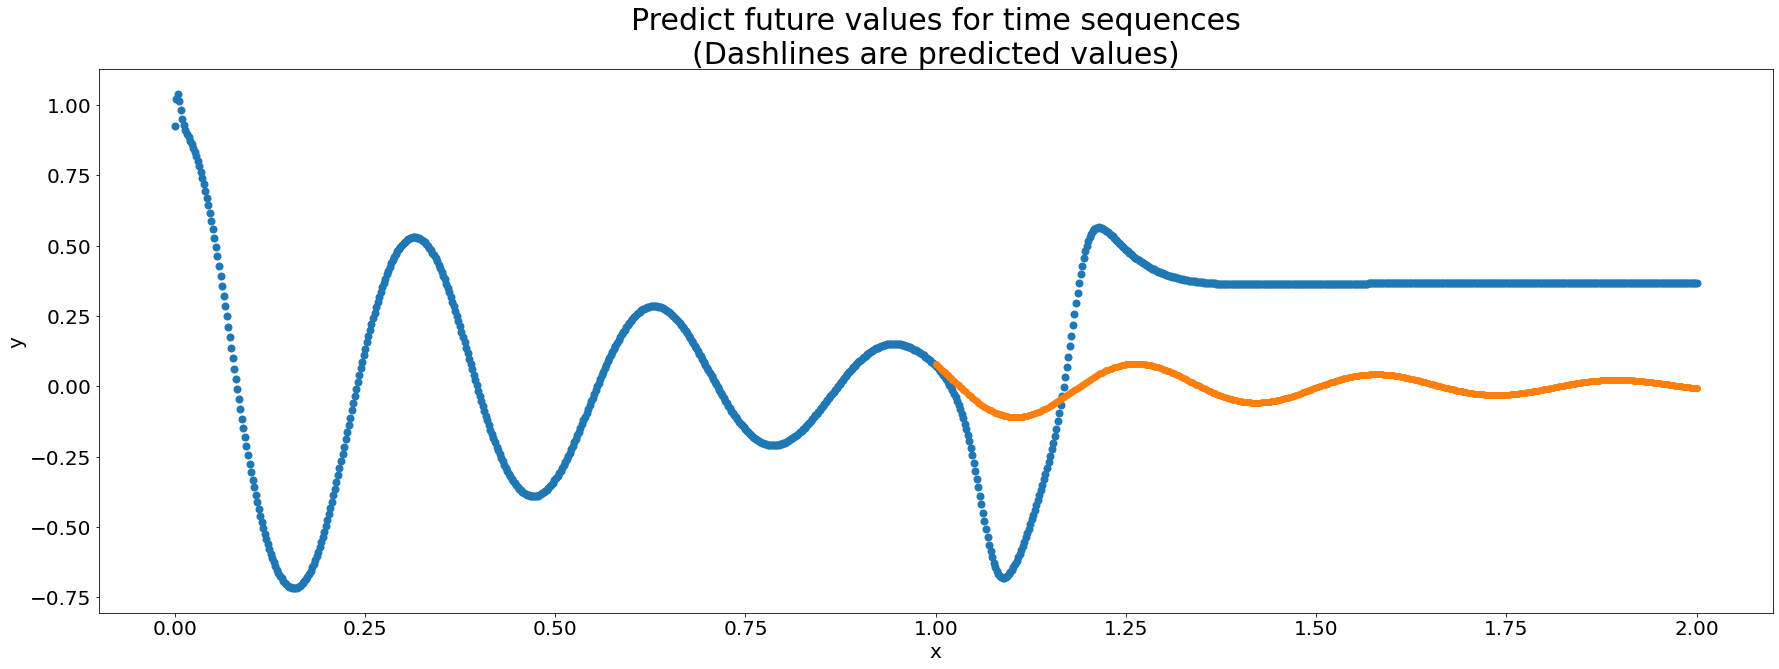

STEP:  3
loss: 6.662806845270097e-05
loss: 6.637394108111039e-05
loss: 6.586503150174394e-05
loss: 6.445005419664085e-05
loss: 6.231520092114806e-05
loss: 5.7358527556061745e-05
loss: 5.0743026804411784e-05
loss: 4.573314799927175e-05
loss: 4.260858622728847e-05
loss: 4.230741615174338e-05
loss: 3.976729203714058e-05
loss: 3.865258258883841e-05
loss: 3.526491127558984e-05
loss: 3.384015872143209e-05
loss: 3.268281579948962e-05
loss: 3.2263305911328644e-05
loss: 3.196096440660767e-05
loss: 3.1816471164347604e-05
loss: 3.171365460730158e-05
loss: 3.1572242733091116e-05
test loss: 3.127178570139222e-05
0.9647931


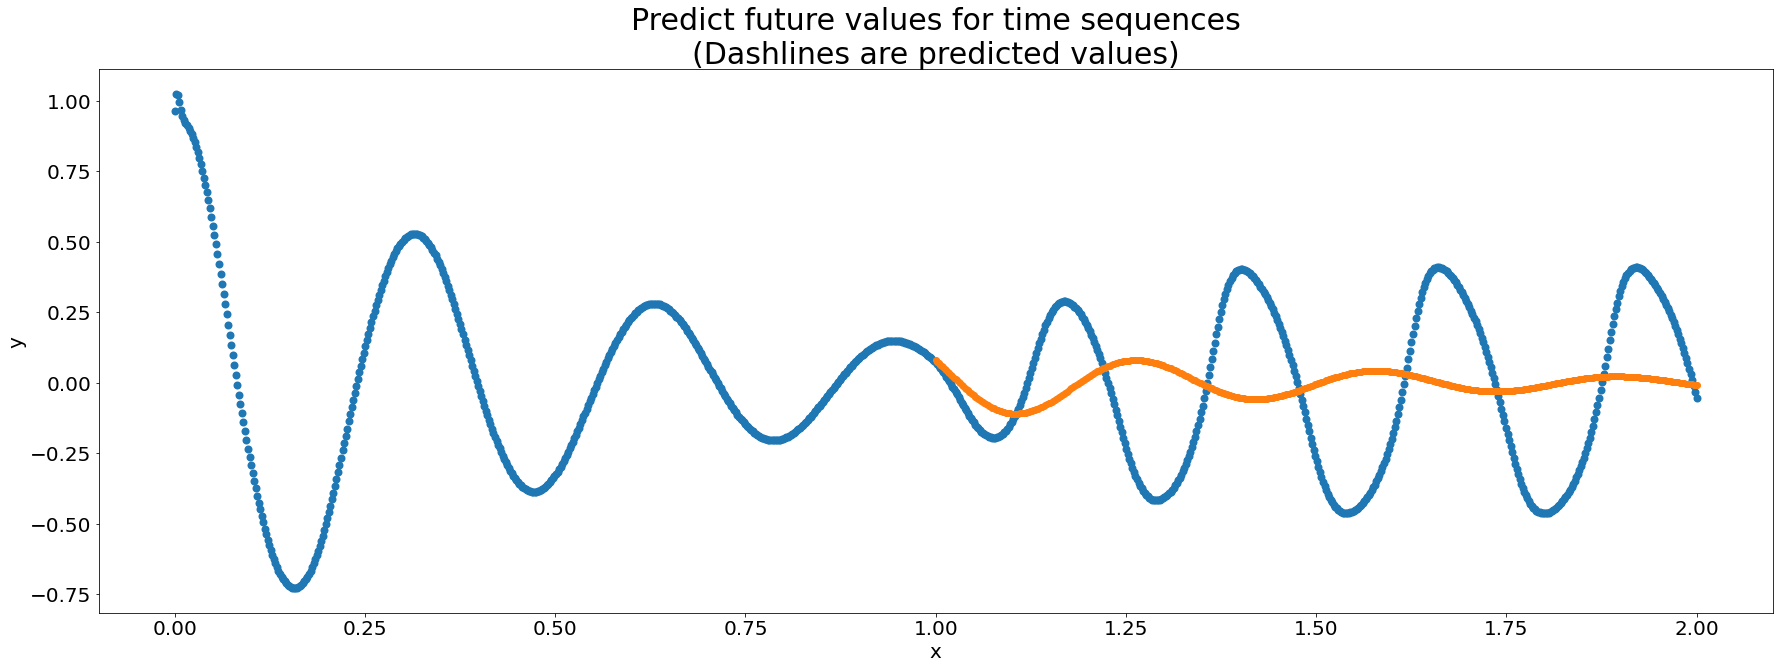

STEP:  4
loss: 3.1271716579794884e-05
loss: 3.0601106118410826e-05
loss: 2.9401076972135343e-05
loss: 2.728778235905338e-05
loss: 2.469899300194811e-05
loss: 2.124357888533268e-05
loss: 1.515632447990356e-05
loss: 1.5838102626730688e-05
loss: 1.1080337571911514e-05
loss: 1.06731185951503e-05
loss: 1.0201672012044583e-05
loss: 9.688277714303695e-06
loss: 9.472216333961114e-06
loss: 9.052620043803472e-06
loss: 8.953731594374403e-06
loss: 8.815160072117578e-06
loss: 8.545591299480293e-06
loss: 8.032468940655235e-06
loss: 7.328109404625138e-06
loss: 6.308283900580136e-06
test loss: 5.838861852680566e-06
0.99843776


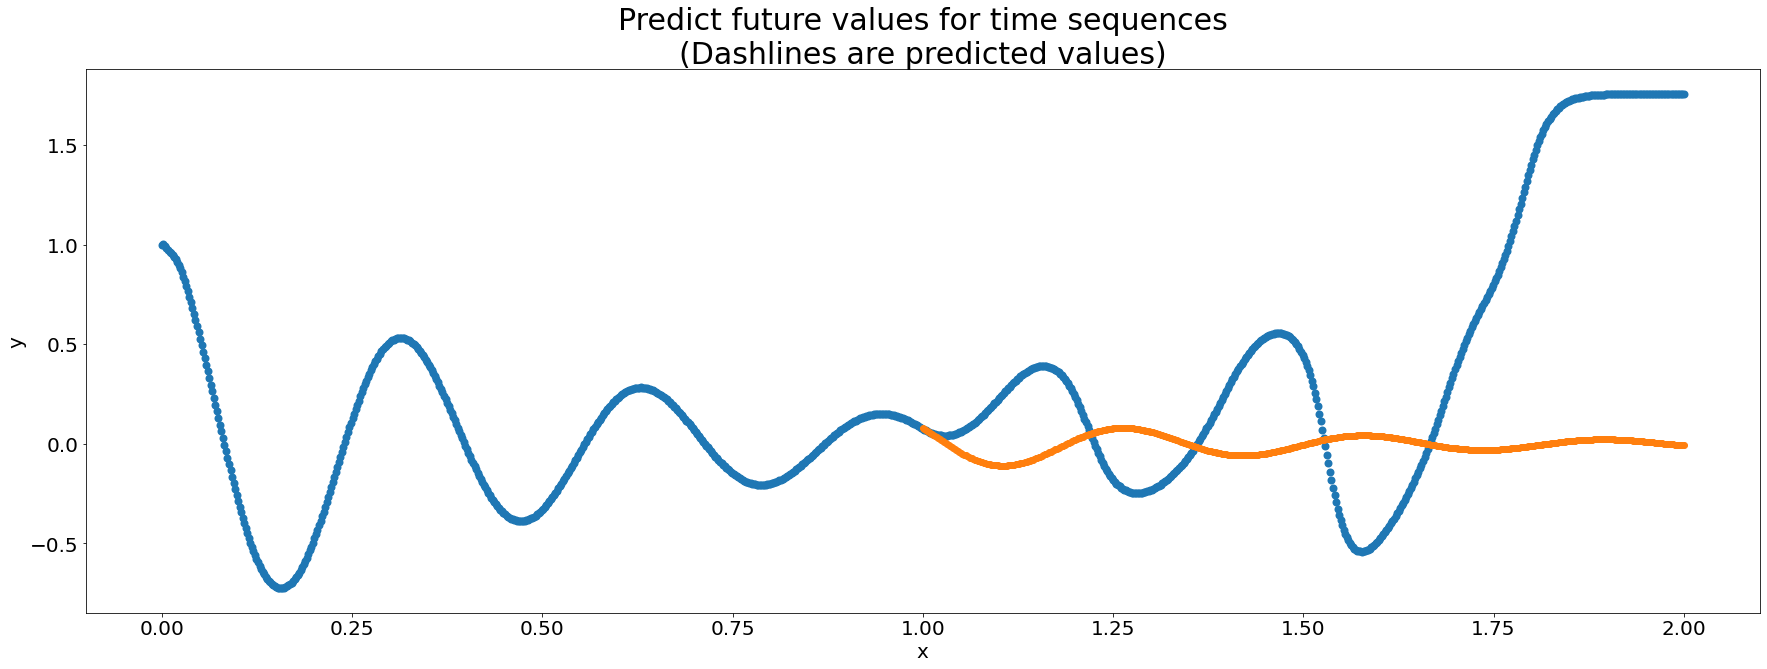

STEP:  5
loss: 5.83885866944911e-06
loss: 7.88969118730165e-05
loss: 4.700542376667727e-06
loss: 4.2614447011146694e-06
loss: 3.920732979167951e-06
loss: 3.601484650062048e-06
loss: 3.3049859666789416e-06
loss: 3.077985866184463e-06
loss: 3.0070211778365774e-06
loss: 2.979551936732605e-06
loss: 2.9602863378386246e-06
loss: 2.9363318390096538e-06
loss: 2.9057353003736353e-06
loss: 2.8776235012628604e-06
loss: 2.849594011422596e-06
loss: 2.8217859835422132e-06
loss: 2.7929818315897137e-06
loss: 2.7678563583322102e-06
loss: 2.742362767094164e-06
loss: 2.6869229259318672e-06
test loss: 2.6044615424325457e-06
0.9863928


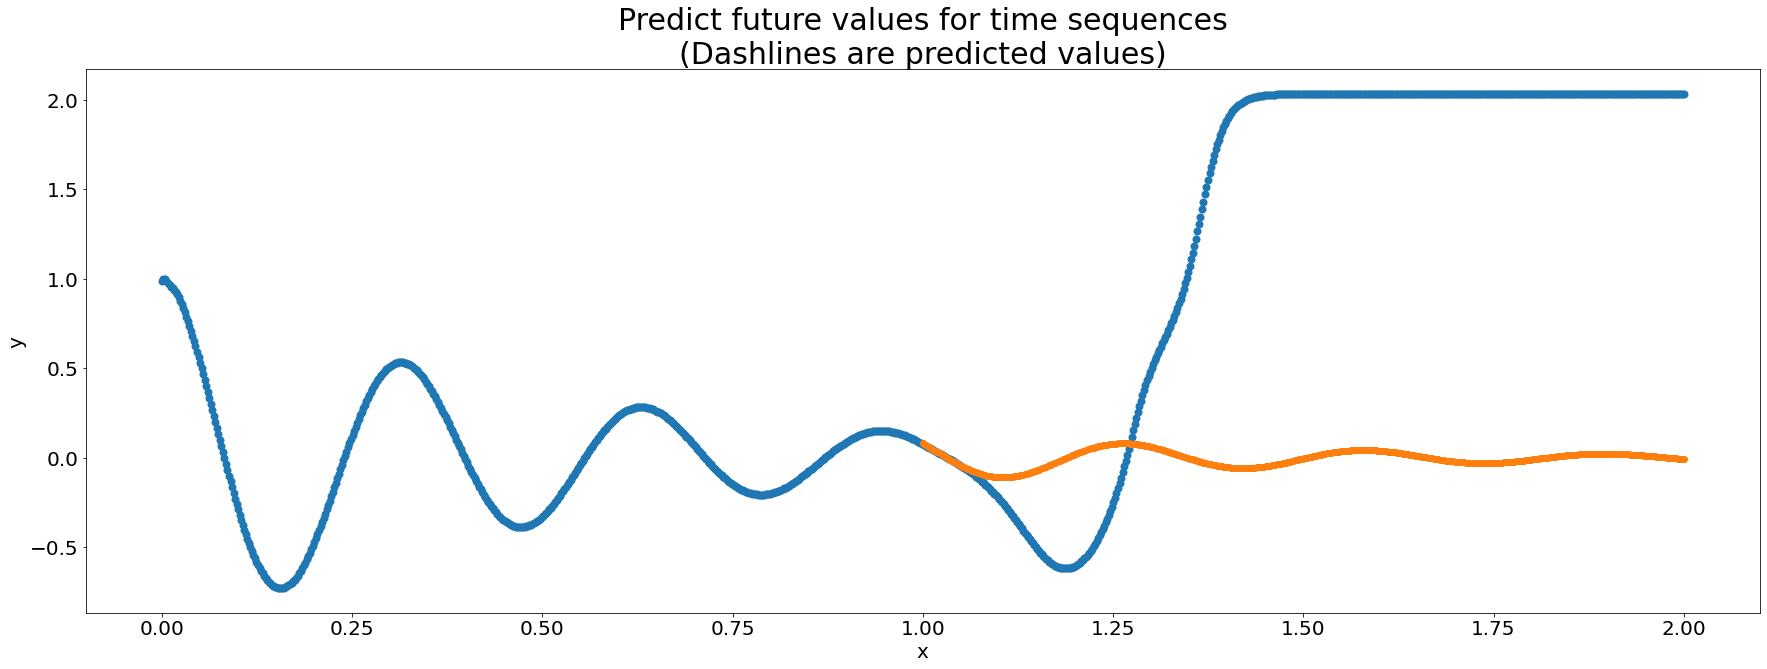

STEP:  6
loss: 2.6044619971798966e-06
loss: 2.5170027129206574e-06
loss: 2.427334493404487e-06
loss: 2.326156845811056e-06
loss: 2.2225028715183726e-06
loss: 2.1010796444898006e-06
loss: 1.9519068246154347e-06
loss: 1.8404250567982672e-06
loss: 1.6745747188906535e-06
loss: 1.5424599268953898e-06
loss: 1.382436380481522e-06
loss: 1.2643517948163208e-06
loss: 1.747291321407829e-06
loss: 1.1351605735399062e-06
loss: 1.0686055702535668e-06
loss: 8.42056749661424e-07
loss: 7.750163035780133e-07
loss: 7.316517667277367e-07
loss: 7.153309979912592e-07
loss: 7.003684459050419e-07
test loss: 6.866673629701836e-07
0.99839824


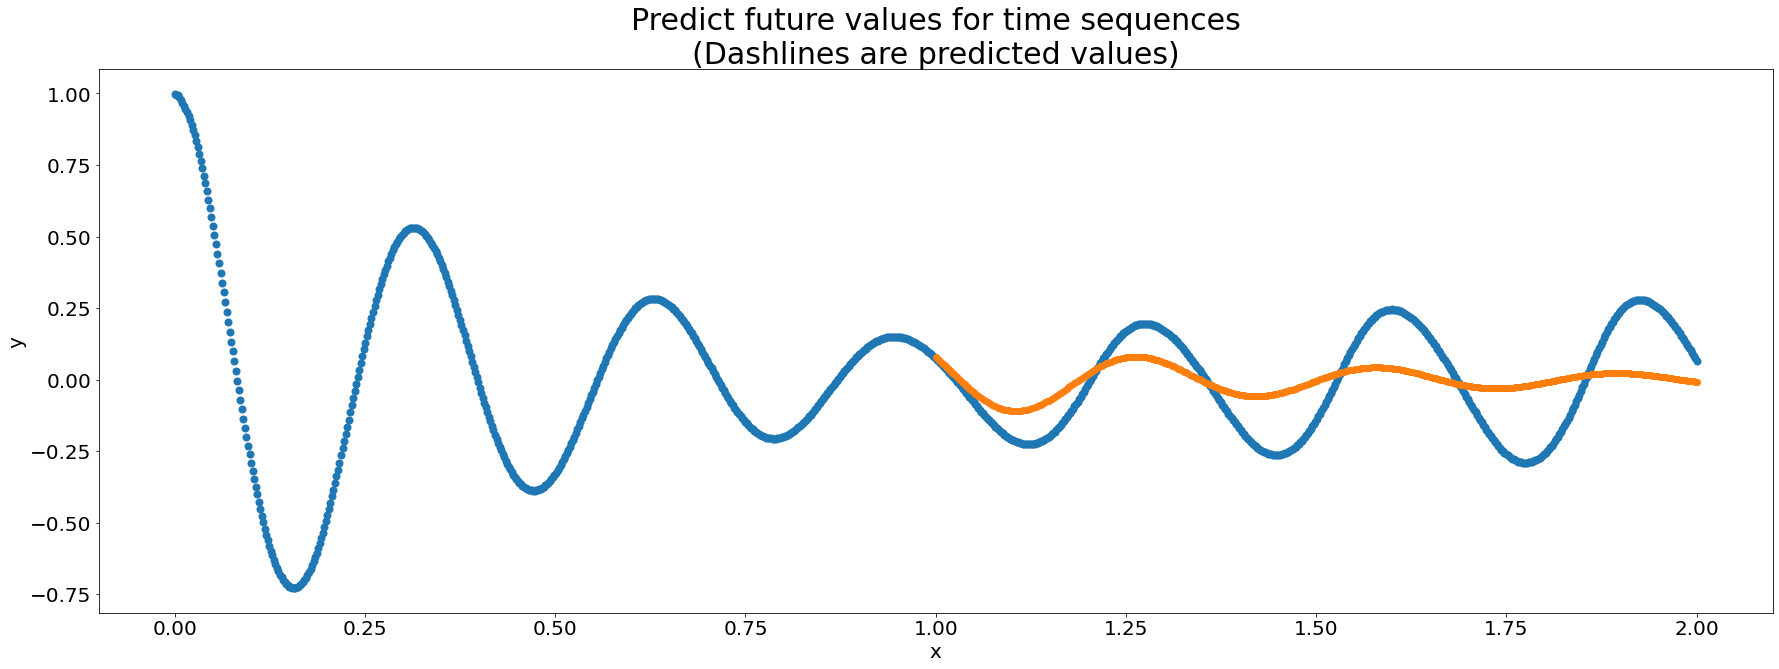

STEP:  7
loss: 6.866638386782142e-07
loss: 6.760687369933294e-07
loss: 6.683019933007017e-07
loss: 6.627379320889304e-07
loss: 6.580382319043565e-07
loss: 6.502941118924355e-07
loss: 6.382910555657872e-07
loss: 6.143164341665397e-07
loss: 5.725268579226395e-07
loss: 5.279621291265357e-07
loss: 4.713697023817076e-07
loss: 4.3247263192824903e-07
loss: 4.158199828907527e-07
loss: 4.103886510620214e-07
loss: 4.0841189274942735e-07
loss: 4.0650490973348496e-07
loss: 4.048997936934029e-07
loss: 4.030855222936225e-07
loss: 4.0141864587894815e-07
loss: 4.005280800356559e-07
test loss: 4.005232483450527e-07
1.0006323


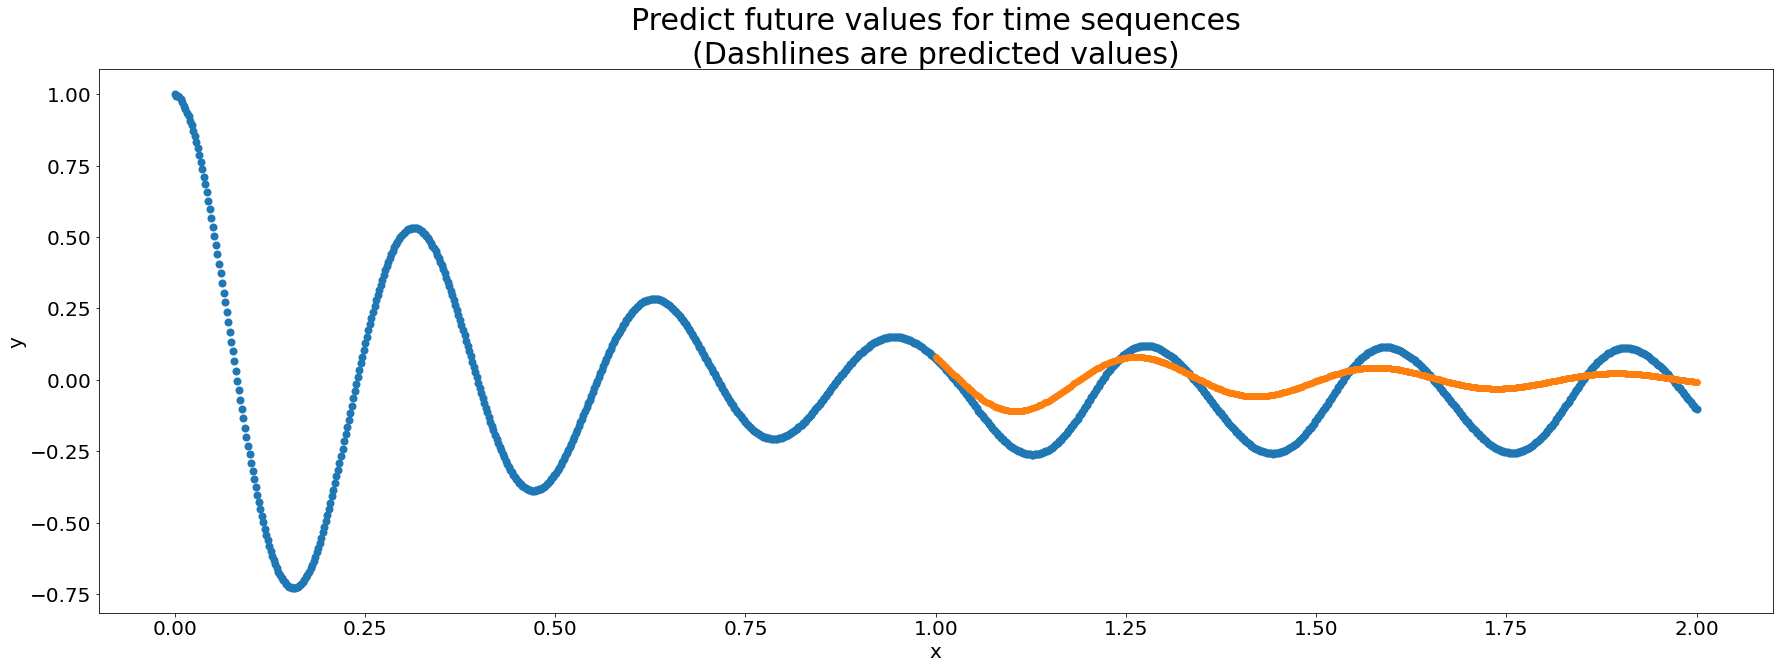

STEP:  8
loss: 4.005280800356559e-07
test loss: 4.005232483450527e-07
1.0006323


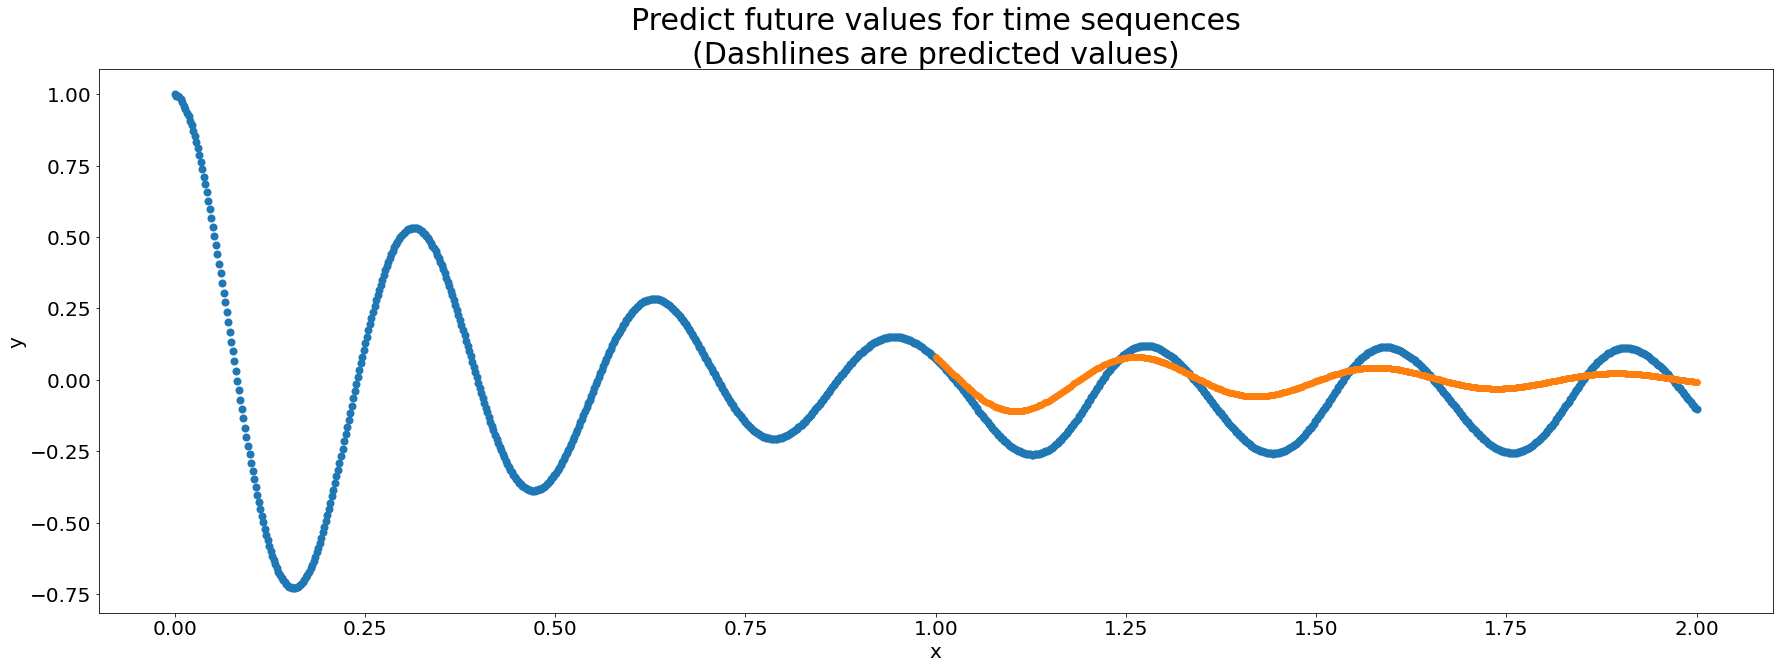

STEP:  9
loss: 4.005280800356559e-07
test loss: 4.005232483450527e-07
1.0006323


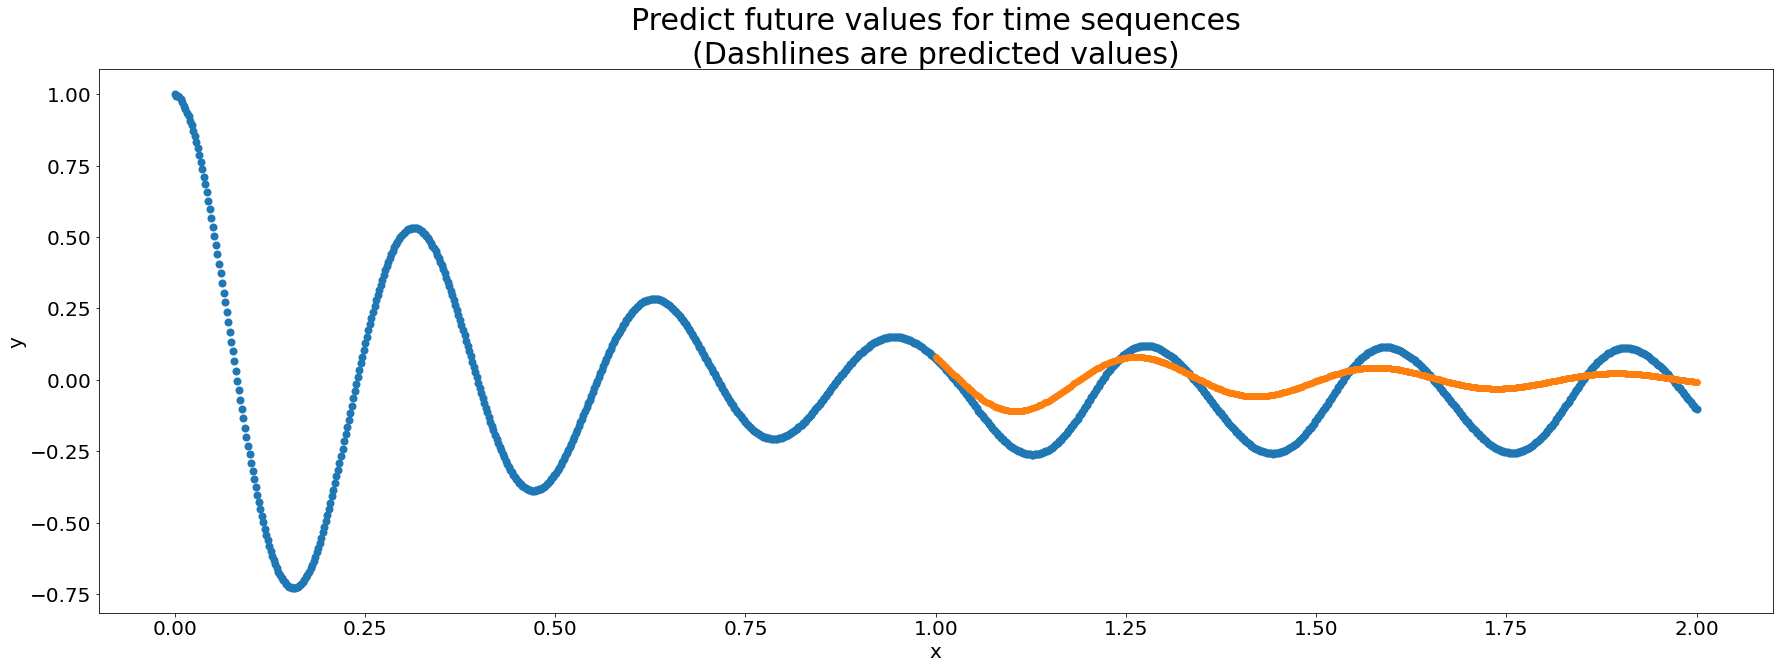

In [10]:

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
inpu = torch.from_numpy(y[3:, :-1])
target = torch.from_numpy(y[3:, 1:])
test_input = torch.from_numpy(y[:3, :-1])
test_target = torch.from_numpy(y[:3, 1:])
# build the model
seq = LSTM()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train

#begin to train

for i in range(10):
    print('STEP: ', i)
    def closure():
        seq.optimizer.zero_grad()
        out = seq(inpu)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    seq.optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq.forward(test_input, future_preds=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    d_t=len(y[:inpu.size(1)][0])
    print((y[:inpu.size(1)][0][0]))
    plt.scatter(np.linspace(0,2,d_t), y[:inpu.size(1)][0], linewidth = 2.0)
    plt.scatter(x_test[1],y_test[1])
    #plt.savefig('plots_lstm/predict%d.jpg'%i)
    plt.show()
    plt.close()

In [ ]:
test_input